In [1]:
import cv2
import glob
import numpy as np
import os
from io import StringIO
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

from collections import Counter

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy.misc import imresize

/Users/lywme/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load and process data

In [13]:
%%time
img_width, img_height = 350,350

images = []
files = glob.glob('Images/*.jpg')
for myFile in sorted(files):
    image = cv2.imread(myFile)
    images.append(image)
myarray = np.asarray(images)

data = myarray.reshape(5500, img_width,img_height,3)
data=data/255.


ratings = pd.read_excel('All_Ratings.xlsx')
filenames = ratings.groupby('Filename').size().index.tolist()
labels = []
for filename in filenames:
    df = ratings[ratings['Filename'] == filename]
    score = round(df['Rating'].mean(), 2)
#     labels.append({'Filename': filename, 'score': score})
    labels.append(score)

# labels_df = pd.DataFrame(labels)
label=np.array(labels)
label=label.reshape(5500,1)

CPU times: user 2min 34s, sys: 11.9 s, total: 2min 46s
Wall time: 3min


In [5]:
label

array([[2.33],
       [3.43],
       [2.9 ],
       ...,
       [3.05],
       [2.4 ],
       [2.67]])

In [6]:
%%time
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,label,test_size=0.1,shuffle=False)

CPU times: user 4.89 s, sys: 31.3 s, total: 36.1 s
Wall time: 1min 47s


### Training ResNexT-50 Regression Model 1

In [21]:
img_width, img_height, channels = 350, 350, 3
input_shape = (img_width, img_height, channels)

In [22]:
resnet = ResNet50(include_top=False, pooling='avg', input_shape=input_shape)
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(batch_size=32, x=x_train, y=y_train, epochs=20)

Epoch 1/20
 544/4950 [==>...........................] - ETA: 46:54 - loss: 2.3467

KeyboardInterrupt: 

### Train CNN Regression model2

In [1]:
inputs = Input(shape=(350, 350, 3))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

NameError: name 'Input' is not defined

In [ ]:
# start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=10, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('model.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    ]
)

In [ ]:
del model
model.save('model.h5')

### load trained model

In [2]:
best_model = load_model('model.h5')

In [8]:
import scipy.ndimage
my_photo = scipy.ndimage.imread('./img/trump.jpg')
my_photo.shape
my_photo=my_photo/255.

/Users/lywme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [9]:
my_photo=my_photo.reshape(1,350,350,3)

In [10]:
best_model.predict(my_photo)

array([[2.3963163]], dtype=float32)

In [4]:
import matplotlib.pyplot as plt
img = load_img('./img/lzl.jpg')
plt.imshow(img)
img = imresize(img, size=(350, 350))
test_x = img_to_array(img).reshape(350, 350, 3)
test_x = test_x / 255.
test_x = test_x.reshape((1,) + test_x.shape)
predicted = best_model.predict(test_x)
preValue=round(predicted[0][0],2)
print("predicted: %.2f" % predicted[0][0])
count=0
for i in labels:
    if i<preValue:
        count=count+1
print("Your beauty surpass ",round((count/len(labels))*100),"% of people in the dataset")

FileNotFoundError: [Errno 2] No such file or directory: './img/lzl.jpg'

In [17]:
%%time
predict=best_model.predict(x_test)

CPU times: user 7min 50s, sys: 16 s, total: 8min 6s
Wall time: 6min 22s


In [18]:
predict

array([[3.1921864],
       [3.7571783],
       [2.9938557],
       [3.0966728],
       [3.0186737],
       [3.0618484],
       [3.0159945],
       [2.8756082],
       [3.302042 ],
       [3.027983 ],
       [3.2169106],
       [2.8793151],
       [3.3193767],
       [3.0124342],
       [3.8180153],
       [3.1659656],
       [3.130352 ],
       [3.0627396],
       [3.1252387],
       [3.4066644],
       [3.2872596],
       [3.1150846],
       [3.7325733],
       [3.6818423],
       [3.3319085],
       [3.2594821],
       [3.032077 ],
       [3.342624 ],
       [3.1377962],
       [3.192495 ],
       [3.6951544],
       [3.0871422],
       [3.389366 ],
       [4.123318 ],
       [3.4145758],
       [2.939169 ],
       [3.449424 ],
       [3.1295478],
       [3.1603587],
       [2.8458774],
       [2.9919298],
       [3.102751 ],
       [3.500374 ],
       [3.3677292],
       [3.0599089],
       [2.899226 ],
       [2.9178383],
       [3.040219 ],
       [4.0578723],
       [2.7605584],


Text(0,0.5,'Predicted value')

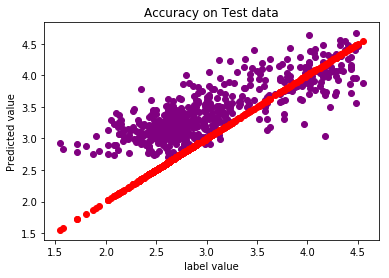

In [49]:
plt.scatter(y_test, predict,color='purple')
plt.plot(y_test, y_test, 'ro')
plt.title("Accuracy on Test data") 
plt.xlabel("label value")
plt.ylabel("Predicted value")

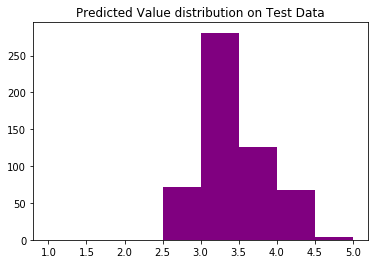

In [50]:
plt.hist(predict, bins =  [1,1.5,2,2.5,3,3.5,4,4.5,5],color='purple') 
plt.title("Distribution of Predicted Values on Test Data") 
plt.show()

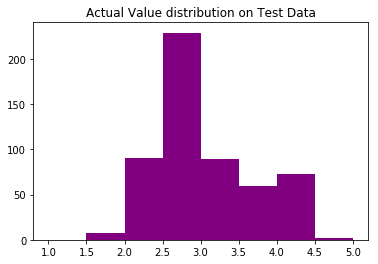

In [51]:
plt.hist(y_test, bins =  [1,1.5,2,2.5,3,3.5,4,4.5,5],color='purple')
plt.title("Distribution of Actual Values on Test Data") 
plt.show()

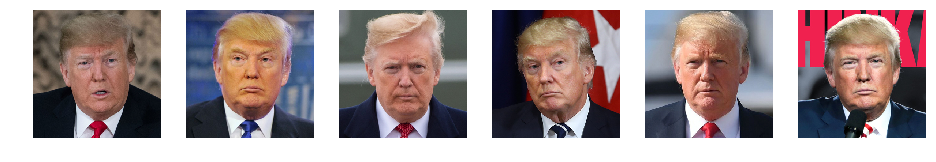

In [10]:
img_test_list = sorted(glob.glob('img/*.jpg'))

imgs_test_resized = []

plt.figure(figsize=(16, 6))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(2, 6, i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_to_array(img).reshape(350, 350, 3)
    img_resized = img_resized / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

In [11]:
imgs_test_resized.shape

(6, 350, 350, 3)

In [12]:
preds=best_model.predict(imgs_test_resized)

In [13]:
preds

array([[2.457973 ],
       [2.0714667],
       [2.0357985],
       [2.1508372],
       [2.5329416],
       [2.452511 ]], dtype=float32)

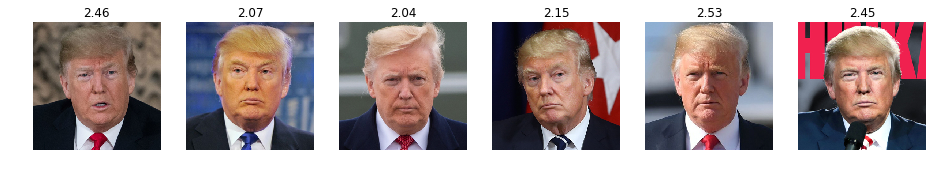

In [14]:
plt.figure(figsize=(16, 6))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(2, 6, i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    plt.imshow(img.squeeze())